## Libraries

In [2]:
from pathlib import Path
import os

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## Data exploration

The data is in multiple files so we first group them together.

In [3]:
# Dictionnary containing test, train and dev datasets (columns : sequence and family_accession)
data_dict = {}
for dirname, _, filenames in os.walk('./random_split'):
    for filename in filenames:
        if "test" in dirname:
            key = "test"
        elif "dev" in dirname:
            key = "dev"
        elif "train" in dirname:
            key = "train"
        else:
            break
        if not key in data_dict.keys():
            data_dict[key] = pd.DataFrame()
        data_dict[key] = pd.concat([data_dict[key], pd.read_csv(os.path.join(dirname, filename))[["sequence", "family_accession"]]])

Here we can identify if some sequences are represented more than once in each dataset. We will check if they are labeled the same way every time (in which case we will keep them), otherwise we will remove these sequences from our dataset.

In [4]:
for dataset in data_dict.keys():
    print(f"-------- {dataset} --------")
    
    # Check for duplicate sequences
    duplicate_sequences = data_dict[dataset]['sequence'].duplicated(keep=False)
    
    print(f" N families : {len(data_dict[dataset]['family_accession'].dropna().unique())}")
    print(f" NA families : {data_dict[dataset]['family_accession'].isnull().sum()}")
    
    print(f" N sequences : {len(data_dict[dataset]['sequence'].dropna().unique())}")
    print(f" Duplicate sequences: {len(np.unique(data_dict[dataset][duplicate_sequences]['sequence']))}")
    print(f" NA sequences : {data_dict[dataset]['sequence'].isnull().sum()}")
    
    print(f" {dataset} shape : {data_dict[dataset].shape}")


-------- test --------
 N families : 13071
 NA families : 0
 N sequences : 126161
 Duplicate sequences: 9
 NA sequences : 0
 test shape : (126171, 2)
-------- train --------
 N families : 17929
 NA families : 0
 N sequences : 1086315
 Duplicate sequences: 233
 NA sequences : 0
 train shape : (1086741, 2)
-------- dev --------
 N families : 13071
 NA families : 0
 N sequences : 126150
 Duplicate sequences: 12
 NA sequences : 0
 dev shape : (126171, 2)


In [5]:
# List of the sequences to be removed
rm_sequences = {'test': [], 'train': [], 'dev': []}

for dataset in data_dict.keys():
    print(f"-------- {dataset} --------")
    # Removing duplicate rows
    print(f"Shape with duplicates : {data_dict[dataset].shape}")
    data_dict[dataset] = data_dict[dataset].drop_duplicates()
    print(f"Shape after removing duplicates : {data_dict[dataset].shape}")

    # Check for duplicate sequences
    duplicate_sequences_rows = data_dict[dataset]['sequence'].duplicated(keep=False)
    duplicate_sequences = data_dict[dataset][duplicate_sequences_rows]['sequence'].value_counts(ascending=False)
    
    # Check for each sequence if they have at least two different labels
    for sequence in duplicate_sequences.index:
        sequence_subset = data_dict[dataset][data_dict[dataset]['sequence']==sequence]
        if len(np.unique(sequence_subset['family_accession'])) > 1:
            print(sequence_subset.head(2))
            # Adding the sequence to the list of sequences to remove
            rm_sequences[dataset].append(sequence)
    
    # Removing the sequences that are labelled differently at least twice
    data_dict[dataset] = data_dict[dataset][~data_dict[dataset]['sequence'].isin(rm_sequences[dataset])]
    print(f"Final shape : {data_dict[dataset].shape}")

-------- test --------
Shape with duplicates : (126171, 2)
Shape after removing duplicates : (126161, 2)
Final shape : (126161, 2)
-------- train --------
Shape with duplicates : (1086741, 2)
Shape after removing duplicates : (1086317, 2)
                                               sequence family_accession
2981  DPLSEEEFYSQFYNQRVKHLCYYHRMKPYLCYQLEQFNGQAPLKGC...        PF18778.1
7400  DPLSEEEFYSQFYNQRVKHLCYYHRMKPYLCYQLEQFNGQAPLKGC...        PF18782.1
                                               sequence family_accession
5367  FYGVTLTAESDSVTWDVDEDYARGQKLVIKQILLGAEAKENEFNVV...       PF03066.15
2690  FYGVTLTAESDSVTWDVDEDYARGQKLVIKQILLGAEAKENEFNVV...        PF17800.1
Final shape : (1086313, 2)
-------- dev --------
Shape with duplicates : (126171, 2)
Shape after removing duplicates : (126150, 2)
Final shape : (126150, 2)


We want to check if some sequences are present in different datasets

In [6]:
test_train_common_sequences = data_dict['test']['sequence'].isin(data_dict['train']['sequence'])
dev_train_common_sequences = data_dict['dev']['sequence'].isin(data_dict['train']['sequence'])
dev_test_common_sequences = data_dict['dev']['sequence'].isin(data_dict['test']['sequence'])

# Get the common sequences
common_test_train_sequences = data_dict['test']['sequence'][test_train_common_sequences]
common_dev_train_sequences = data_dict['dev']['sequence'][dev_train_common_sequences]
common_dev_test_sequences = data_dict['dev']['sequence'][dev_test_common_sequences]

# Check if any 'sequence' in common between train/test/dev
any_test_train = common_test_train_sequences.any()
any_dev_train = common_dev_train_sequences.any()
any_dev_test = common_dev_test_sequences.any()

print(f"Any values in data_dict['test']['sequence'] are in data_dict['train']: {any_test_train}")
if any_test_train:
    print(f"N Common sequences : {len(common_test_train_sequences)}")

print(f"Any values in data_dict['dev']['sequence'] are in data_dict['train']: {any_dev_train}")
if any_dev_train:
    print(f"N Common sequences : {len(common_dev_train_sequences)}")

print(f"Any values in data_dict['dev']['sequence'] are in data_dict['test']: {any_dev_test}")
if any_dev_test:
    print(f"N Common sequences : {len(common_dev_test_sequences)}")

# Removing from test the sequences that are already in train
data_dict['test'] = data_dict['test'][~data_dict['test']['sequence'].isin(common_test_train_sequences)]
print(f"Final test shape : {data_dict['test'].shape}")

# Removing from dev the sequences that are already in train
data_dict['dev'] = data_dict['dev'][~data_dict['dev']['sequence'].isin(common_dev_train_sequences)]
# Removing from test the sequences that are already in dev
data_dict['dev'] = data_dict['dev'][~data_dict['dev']['sequence'].isin(common_dev_test_sequences)]
print(f"Final dev shape : {data_dict['dev'].shape}")

Any values in data_dict['test']['sequence'] are in data_dict['train']: True
N Common sequences : 60
Any values in data_dict['dev']['sequence'] are in data_dict['train']: True
N Common sequences : 67
Any values in data_dict['dev']['sequence'] are in data_dict['test']: True
N Common sequences : 18
Final test shape : (126101, 2)
Final dev shape : (126079, 2)


We also want to check that all the family classes in test and dev datasets are at least represented once in the train dataset.

In [7]:
test_common_families = data_dict['test']['family_accession'].isin(data_dict['train']['family_accession'])
dev_common_families = data_dict['dev']['family_accession'].isin(data_dict['train']['family_accession'])

# Check if all values in 'family_accession' of test/ dev are in train
all_test_in_train = test_common_families.all()
all_dev_in_train = dev_common_families.all()

print(f"All values in data_dict['test']['family_accession'] are in data_dict['train']: {all_test_in_train}")
print(f"All values in data_dict['dev']['family_accession'] are in data_dict['train']: {all_dev_in_train}")

All values in data_dict['test']['family_accession'] are in data_dict['train']: True
All values in data_dict['dev']['family_accession'] are in data_dict['train']: True


## Data statistics

We can now start looking at the length of the sequences : are they all the same or do they vary a lot ?

< test > Min length: 9, Max length: 1937


< train > Min length: 4, Max length: 2037
< dev > Min length: 9, Max length: 1971


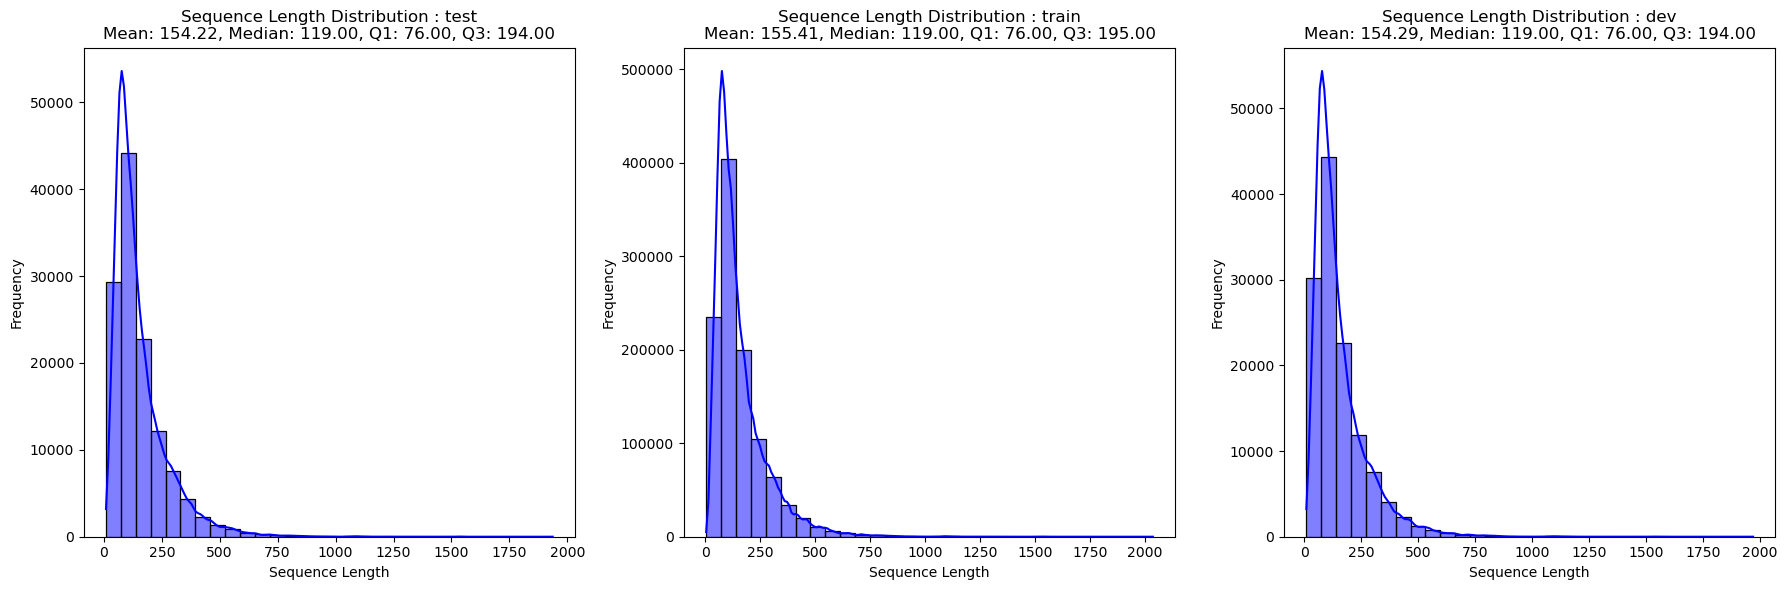

In [8]:
plt.figure(figsize=(18, 6))

for i, dataset in enumerate(data_dict.keys()):
    
    sequence_lengths = data_dict[dataset]['sequence'].apply(len)
    print(f"< {dataset} > Min length: {sequence_lengths.min()}, Max length: {sequence_lengths.max()}")
    
    # Calculate mean and quartiles
    mean_length = np.mean(sequence_lengths)
    median_length = np.median(sequence_lengths)
    q1 = np.percentile(sequence_lengths, 25)
    q3 = np.percentile(sequence_lengths, 75)
    
    # Plot the histogram of sequence lengths
    plt.subplot(1, 3, i+1)
    sns.histplot(sequence_lengths, bins=30, kde=True, color='blue')
    plt.title(f'Sequence Length Distribution : {dataset}\nMean: {mean_length:.2f}, Median: {median_length:.2f}, Q1: {q1:.2f}, Q3: {q3:.2f}')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    
plt.tight_layout()
plt.show()

What is the distribution of the amino acids ? Does it match with the description of the database : "There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z"

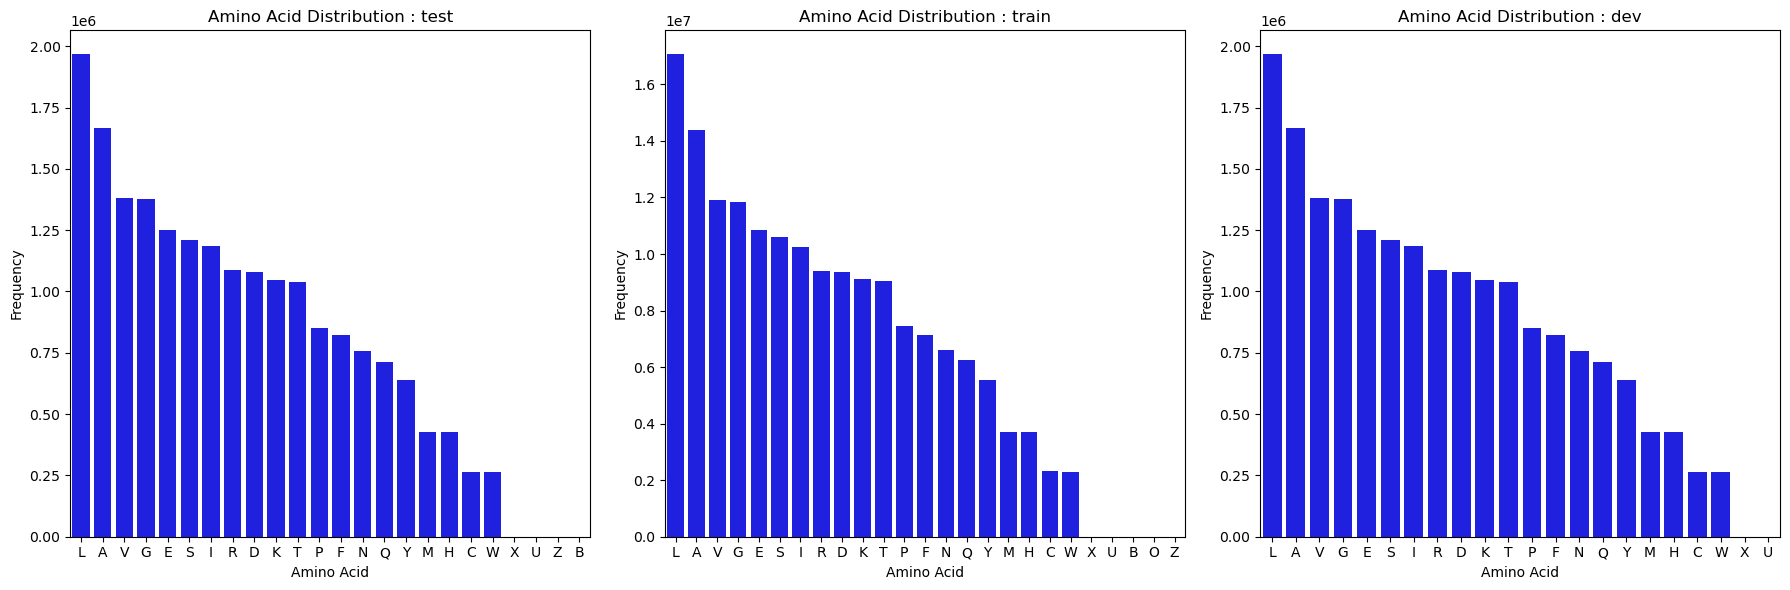

In [9]:
plt.figure(figsize=(18, 6))

for i, dataset in enumerate(data_dict.keys()):

    sequences = data_dict[dataset]['sequence']
    all_amino_acids = ''.join(sequences)
    amino_acid_counts = Counter(all_amino_acids)
    amino_acids, counts = zip(*amino_acid_counts.items())
    
    # Sort amino acids by frequency
    sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
    amino_acids = [amino_acids[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]
    
    # Plot the bar chart for amino acid distribution
    plt.subplot(1, 3, i+1)
    sns.barplot(x=list(amino_acids), y=list(counts), color='blue')
    plt.title(f'Amino Acid Distribution : {dataset}')
    plt.xlabel('Amino Acid')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

We can also wonder about class imbalance.

< test >
family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
PF00677.17    187
PF01035.20    168
PF02417.15    157
PF13472.6     156
PF00684.19    151
Name: count, dtype: int64
< train >
family_accession
PF13649.6     3637
PF00560.33    1927
PF13508.7     1761
PF06580.13    1537
PF02397.16    1528
PF00677.17    1504
PF01035.20    1345
PF02417.15    1265
PF13472.6     1252
PF00684.19    1210
Name: count, dtype: int64
< dev >
family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
PF00677.17    187
PF01035.20    168
PF02417.15    157
PF13472.6     156
PF00684.19    151
Name: count, dtype: int64


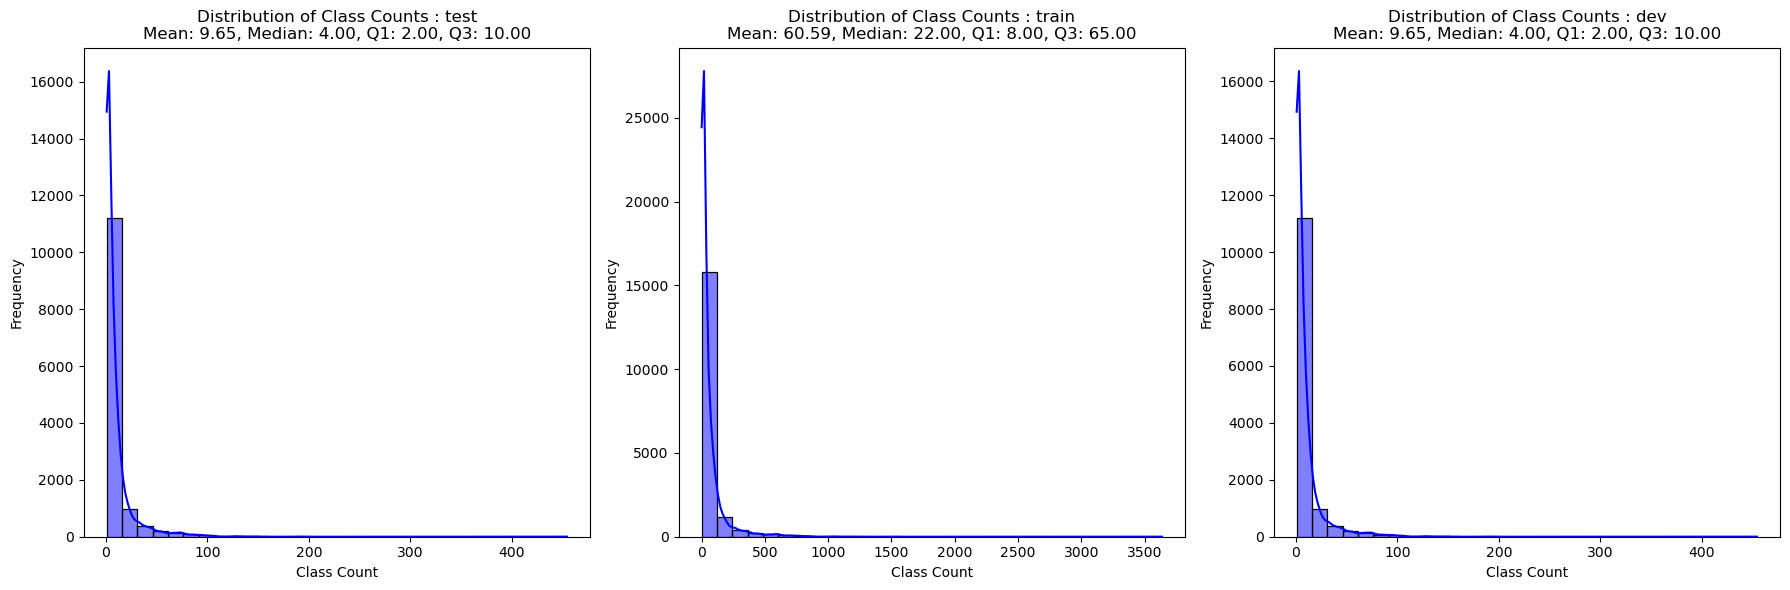

In [10]:
plt.figure(figsize=(18, 6))

for i, dataset in enumerate(data_dict.keys()):
    class_counts = data_dict[dataset]['family_accession'].value_counts()
    print(f'< {dataset} >')
    print(class_counts.head(10))

    # Calculate mean and quartiles
    mean_length = np.mean(class_counts)
    median_length = np.median(class_counts)
    q1 = np.percentile(class_counts, 25)
    q3 = np.percentile(class_counts, 75)
    # Plot the histogram of class counts
    plt.subplot(1, 3, i+1)    
    sns.histplot(class_counts, bins=30, kde=True, color='blue')
    plt.xlabel('Class Count')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Class Counts : {dataset}\nMean: {mean_length:.2f}, Median: {median_length:.2f}, Q1: {q1:.2f}, Q3: {q3:.2f}')

plt.tight_layout()
plt.show()

**Summary :**

1- No Missing values

2- Duplicated values handled

3- Distribution of sequence lengths log normal and similar between train - dev - test

4- Similar distribution of AA in train - dev - test sets and in accordance with the data description : "There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z" except for C and W which appear to have a frequency lower than 1e6 (when considering the three datasets combined).

5- Class imbalance but the classes seem to be similarly represented in each set (the top 10 classes are the same in train, dev and test)

Saving the three datasets

In [11]:
for name, dataset in data_dict.items(): 
    dataset.to_csv(f"./random_split/{name}.csv")